## Baby attempt at algorithm for determining transects

### some notes
`isel` with `xr` coordinate (index).\
Returns datavariable in `n` coordinate (ID).

## Part 1: Create mask
### Objective
We will use the mask to select all of the cells that appear in the original mask. We will

<ol>
    <li>Select all of the cells that appear in the original mask.</li>
    <li>Of those cells, select their corresponding vertices and edges to include inside the mask (this prevents cells from being halved if the original mask were to be applied).</li>
    <li>Select these cells, edges, and vertices in the base_mask to create a new mask.</li>
    <li>Apply this mask to the dso datavariable to plot the datavariable in the new masked area.</li>
</ol>

In [29]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools
from mpas_tools.planar_hex import make_planar_hex_mesh
from mpas_tools.mesh.conversion import convert, cull, mask
from mpas_tools.io import write_netcdf
from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from geometric_features import read_feature_collection
from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import json
import mosaic

### Set up datasets
**To create a base mask (a global "mask" filled with 1s):**
```ruby
# create a global base mask of ones everywhere. 
# We will then apply the mask where we specifically choose nCells, nVertices, and nEdges that are contained in the original mask to this basemask 
# This creates a new mask with all parts of the cell included. 


# create a base mask
mask['regionCellMasks'] = mask.regionCellMasks * 0 + 1
mask['regionVertexMasks'] = mask.regionVertexMasks * 0 + 1
mask['regionEdgeMasks'] = mask.regionEdgeMasks * 0 + 1
mask['regionNames'] = 'whole cell LS'
mask.attrs['How to use'] = 'open separate dataset with nCell, nVertices, nEdges xr index arrays. base_mask.regionCellMasks.where(base_mask.nCells.isin(cells_inside),other = 0)'
mask.to_netcdf('/global/homes/k/kuyeda/WMT_NBs/mpas-o_EC30to60_global_base_mask.nc',format='netCDF4',mode='w')
mask
```

**To convert the original mask .geojson file to a .nc file:**
```ruby
# convert geojson to .nc mask file

wmtnb_filepath = '/global/u2/k/kuyeda/WMT_NBs/'
fcMask = read_feature_collection(wmtnb_filepath + 'LS_test.geojson')
# pool = create_pool(process_count=8)
dsMasks = compute_mpas_region_masks(
    dsMesh, fcMask, maskTypes=('cell', 'vertex', 'edge'), pool=pool
)
# dsMasks.to_netcdf(wmtnb_filepath + 'LS_CEV_masks.nc', format='NETCDF4', mode='w')
```

### Open necessary datasets
```mesh``` $\rightarrow$ contains information about the mesh and cells \
```dso``` $\rightarrow$ diagnostics from the simulations (datavariables we actually want to plot) \
```mask``` $\rightarrow$ a mask of 0s and 1s created from a geojson file (created using geojson.io) that was then converted into a netcdf file using ```compute_mpas_region_masks``` \
```base_mask``` $\rightarrow$ a mask of 1s for the entire globe.


In [30]:
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')

# open original (from geojson file) mask to use to make dataset smaller
wmtnb_filepath = './'
mask = xr.open_dataset(wmtnb_filepath + 'LS_CEV_masks.nc')

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')

/tmp/ipykernel_580847/3657922681.py:10: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')


### functions to convert between index (xr) and ID (n) 

In [57]:
def n_to_xr_idx(n):
    return n-1

def xr_to_n_idx(xr):
    return xr+1

This code below can be rewritten to use `mesh.indexToEdgeID` or something related to it, but the I/O was messed up the day that I was doing this, so we're using the `n_to_xr_idx` and the `xr_to_n_idx` functions.
Also, just subtracting one feels easier and there is a straightforward conversion from ID (n) to index (xr) values. But the equivalent functions are below
```ruby
def xr_to_n_idx(xr):
    return xr+1
```

The equivalent conversion from  the index (xr) to ID (n) is
```ruby
cell_part = 'Cell' # 'Edge', 'Vertex'
ds = mesh
def idx_to_id(idx,cell_part,ds):
    id = ds[f'indexTo{cell_part}ID'].isel(nCells=idx).values
    return id
```

### function to get cells, edges, and vertices inside a mask

In [50]:
def xr_inside_mask_info(mesh,mask):
    # STEP 1: Select all of the cells inside teh mask
    # create mask of cells so that whole cells are included in the mask
    cellmask = mask.regionCellMasks.isel(nRegions=0).astype(bool)
    
    # --------- GET CELLS IN XR COORDINATES --------------
    # apply the mask to the mesh 
    # this returns cells in the xr coordinate
    xr_cells_inside = np.int32(mesh.nCells.where(cellmask,drop=True))
    
    # --------- GET VERTICES IN XR COORDINATES --------------
    
    # we also need all the vertices associated with the cells_inside masked mesh
    # this returns vertices in the n coordinate
    n_vertices_inside = mesh.verticesOnCell.isel(nCells=xr_cells_inside)
    
    # we want the vertices in the xr coordinate
    xr_vertices_inside_raw = n_to_xr_idx(n_vertices_inside)
    
    # remove repeat vertex values, remove -1 values (these were originally 0s and represented "blank" array spaces where there were fewer than 7 vertices
    xr_vertices_inside = np.delete(np.unique(xr_vertices_inside_raw), np.unique(xr_vertices_inside_raw)==-1)
    
    # --------- GET EDGES IN XR COORDINATES --------------
    
    # we also need all the edges associated with the cells_inside masked mesh
    # this returns edges in the n coordinate
    n_edges_inside = mesh.edgesOnCell.isel(nCells=xr_cells_inside)
    
    # we want  the edges in the xr coordinate
    xr_edges_inside_raw = n_to_xr_idx(n_edges_inside)
    
    # remove repeat edge values, remove -1 values (these were originally 0s and represented "blank" array spaces where there were fewer than 7 edges
    xr_edges_inside = np.delete(np.unique(xr_edges_inside_raw), np.unique(xr_edges_inside_raw)==-1)

    return xr_cells_inside, xr_vertices_inside, xr_edges_inside

### Step 1 & 2. Select all of the cells that appear inside the original mask and their corresponding vertices and edges. 

In [51]:
cells_inside, vertices_ids, edges_inside = xr_inside_mask_info(mesh,mask)

### Step 3. Create a new mask that contains all of the cells inside with their corresponding vertices and edges. 

In [52]:
base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(cells_inside), other = 0)
base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(vertices_ids), other = 0)
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(edges_inside), other = 0)
LS_mask_whole_cells = base_mask

In [55]:
# convert the 1s and 0s new mask to boolean T/F
cellmask = LS_mask_whole_cells.regionCellMasks.isel(nRegions=0).astype(bool)
edgemask = LS_mask_whole_cells.regionEdgeMasks.isel(nRegions=0).astype(bool)
vertexmask = LS_mask_whole_cells.regionVertexMasks.isel(nRegions=0).astype(bool)

### Step 4. Apply this mask to the dso variable to plot the datavariable in the new masked area. 

(51.5, 68.0)

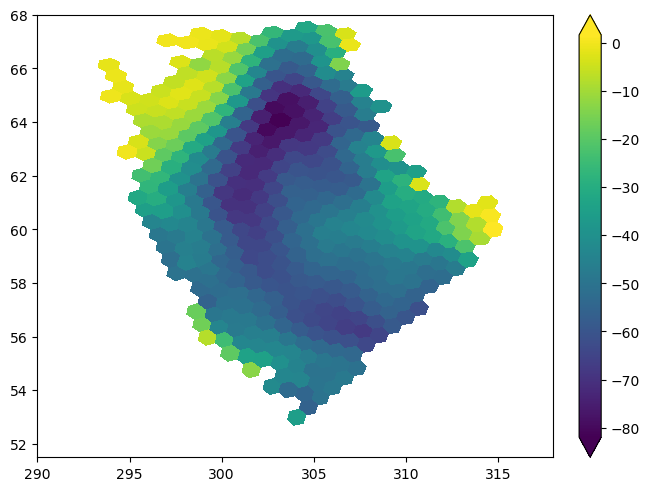

In [54]:

# scratch plot to check stuff
# set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)


# ds_t0 = dso['timeMonthly_avg_activeTracers_temperature'].isel(nVertLevels=30,Time=0)

ds_t0 = dso['timeMonthly_avg_latentHeatFlux'].isel(Time=0)

# remove the nans
if ds_t0.min() < -9**33:
    ds_nonans = ds_t0.where(ds_t0 > -9**33)
    print('fake nans detected')
else:
    ds_nonans = ds_t0

# apply the mask
ds_masked = ds_nonans.where(cellmask,drop=False)

# plot
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  ds_masked,cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')
ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)

<div class="alert alert-block alert-info">
<b>All above this is correct:</b> Stop.
</div>

## Part 2: Algorithm to create transects

### function to select dso data inside mask

In [58]:
def format_ds(cells_inside_ints, ds, datavariable):
    # select just the cells in the masked area
    ds_masked = ds[datavariable].isel(nCells=cells_inside_ints)

    # remove the nans
    if ds_masked.min() > 10**33:
        print('fake nans detected')
        ds_nonans = ds_masked.where(ds != ds_masked.min())
    else:
        ds_nonans = ds_masked

    # select a specific time
    ds_formatted = ds_nonans.to_dataset(name=datavariable)
    
    return ds_formatted

In [61]:
# Find the vertext\ closest to the latitudes at which you want to start. 

ds_masked

<xarray.DataArray 'timeMonthly_avg_latentHeatFlux' (nCells: 236853)> Size: 947kB
array([nan, nan, nan, ..., nan, nan, nan], shape=(236853,), dtype=float32)
Dimensions without coordinates: nCells
Attributes:
    units:      W m^{-2}
    long_name:  Latent heat flux at cell centers from coupler. Positive into ...

In [60]:
# id the edges attached to the start vertex
e_id = mesh.edgesOnVertex.isel(nVertices=start_idx)

# grab one of the edges that is attached to the vertex. then subtract to make an index
edge_idx0 = e_id.isel(vertexDegree=0) - 1

# get the vertices attached to the other side
next_vid = mesh.verticesOnEdge.isel(nEdges=edge_idx0)

# eliminate the previous vertex id from the array
next_vid.where(next_vid!= start_vid.values).dropna(dim='TWO')

NameError: name 'start_idx' is not defined

### check indices between n and xr for Cells
`isel` with `xr` coordinate.\
Returns datavariable in `n` coordinate.

In [15]:
# get the edges connected to a cell with the xr_ID of 0 (isel(nCells=0)). Then choose the first edge of that cell
# returns edges in the n coordinate
edge_nCell0_0 = mesh.edgesOnCell.isel(nCells=0).values[0] 
display(edge_nCell0_0)

# convert the edge in the n coordinate to the xr coordinate (xr = n -1) 
xr_edge_nCell0_0 = edge_nCell0_0 -1
display(xr_edge_nCell0_0)

# check our work 
# get the cells connected to an edge identified with xr_ID and n
mesh.cellsOnEdge.isel(nEdges=xr_edge_nCell0_0).values
# indices returned in the ncell indices

np.int32(288637)

np.int32(288636)

array([     1, 234052], dtype=int32)

### check indices between n and xr for Vertices

In [16]:
# get the vertices connected to a cell with the xr_ID of 0 (isel(nCells=0)). then choose the first vertex of that cell
# returns vertices in the n coordinate
nCell_idx = 0
vert_nCell0_0 = mesh.verticesOnCell.isel(nCells=nCell_idx).values[0]
display(vert_nCell0_0)

# convert the vertex in the n coordinate to the xr coordinate (xr = n-1)
xr_vert_nCell0_0 = n_to_xr_idx(vert_nCell0_0)
display(xr_vert_nCell0_0)

# check our work
# get the cells connected to the vertex identified with xr_ID and n
nCell_vert31235_0 = mesh.cellsOnVertex.isel(nVertices = xr_vert_nCell0_0).values

# indices returned in the ncell indices. Convert ncell index to xr index
nCell_from_vertex = n_to_xr_idx(nCell_vert31235_0)
display(nCell_from_vertex)


np.int32(31236)

np.int32(31235)

array([234050,      0, 234051], dtype=int32)

### make plots

In [17]:
# create mask 
# cells_inside, vertices_ids = create_mask(mesh,mask)
cells_inside, vertices_ids, edges_inside = xr_inside_mask_info(mesh,mask)

# apply mask to simulation data
ds_formatted0 = format_ds(cells_inside,dso,'timeMonthly_avg_activeTracers_temperature')
ds_formatted = ds_formatted0.isel(Time=0)

# apply mask to mesh data
mesh_mask_lat = format_ds(cells_inside,mesh,'latCell')
mesh_mask_lon = format_ds(cells_inside,mesh,'lonCell')

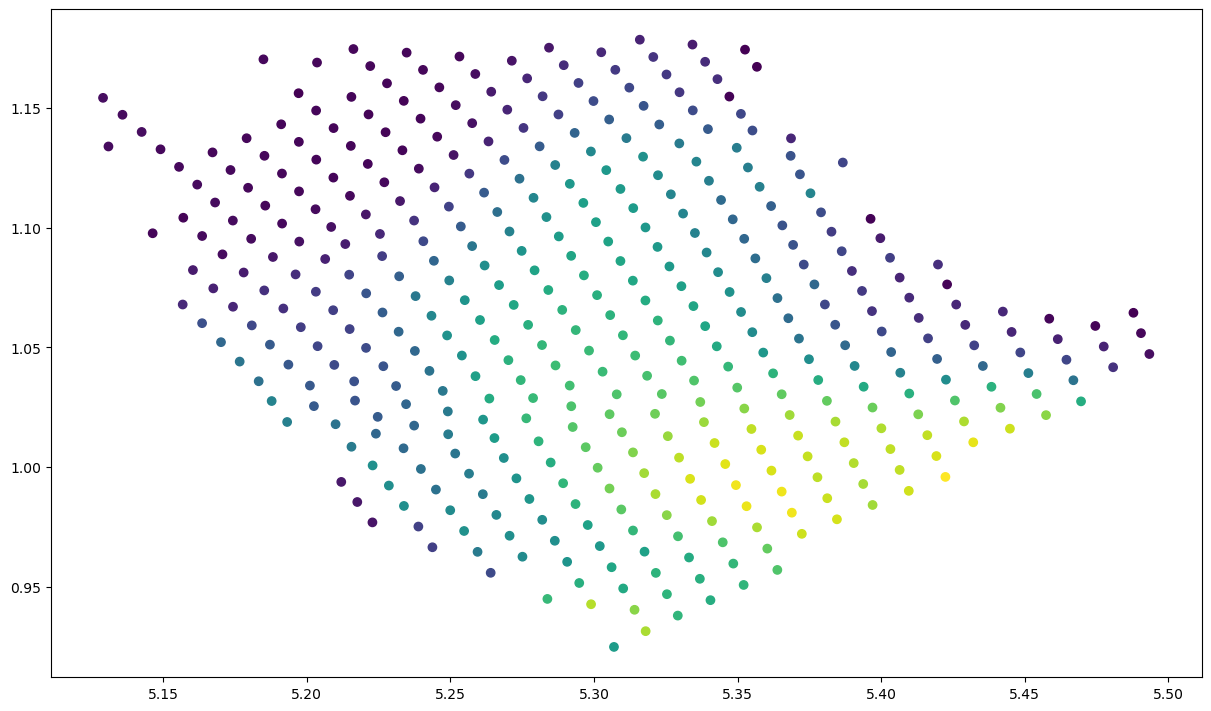

In [18]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(12,7))
c_ds = ds_formatted['timeMonthly_avg_activeTracers_temperature'].isel(nVertLevels=0)
ax.scatter(mesh_mask_lon.lonCell, mesh_mask_lat.latCell, c=c_ds)# , s=0.1, cmap=cmo.balance)

In [19]:
# # select datavariables and dimensions to make data smaller & it's easier to deal with
# ds_name = 'timeMonthly_avg_activeTracers_temperature'
# ds = dso[ds_name]
# # create nans
# ds_nans = ds.where(ds != ds.min()).to_dataset(name='Temp').isel(Time=0)

# # apply mask to select just the LS(ish)
# # establish masks
# cellmask = mask.regionCellMasks.isel(nRegions=0).astype(bool)
# edgemask = mask.regionEdgeMasks.isel(nRegions=0).astype(bool)
# vertexmask = mask.regionVertexMasks.isel(nRegions=0).astype(bool)

# # specify which mask based on coordinates of datavariable
# if 'nCells' in ds_nans.dims:
#     grid_mask = cellmask
# elif 'nEdges' in ds_nans.dims:
#     grid_mask = edgemask

    
# ds_masked = ds_nans.where(grid_mask,drop=False)

In [20]:
mesh

<xarray.Dataset> Size: 1GB
Dimensions:                        (nCells: 236853, nEdges: 719506,
                                    nVertices: 482371, TWO: 2, maxEdges: 7,
                                    maxEdges2: 14, vertexDegree: 3,
                                    nVertLevels: 60, Time: 1,
                                    nVertLevelsP1: 61, nForcingGroupsMax: 4)
Coordinates:
    VertexID                       (nVertices) int32 2MB 1 2 3 ... 482370 482371
Dimensions without coordinates: nCells, nEdges, nVertices, TWO, maxEdges,
                                maxEdges2, vertexDegree, nVertLevels, Time,
                                nVertLevelsP1, nForcingGroupsMax
Data variables: (12/73)
    latCell                        (nCells) float64 2MB 1.57 -0.4633 ... 0.1429
    lonCell                        (nCells) float64 2MB 5.919 0.6299 ... 2.347
    xCell                          (nCells) float64 2MB ...
    yCell                          (nCells) float64 2MB ...
    zCell                          (nCells) float64 2MB ...
    indexToCellID                  (nCells) int32 947kB ...
    ...                             ...
    accumulatedLandIceFrazilMass   (Time, nCells) float64 2MB ...
    frazilSurfacePressure          (Time, nCells) float64 2MB ...
    filteredSSHGradientZonal       (Time, nCells) float64 2MB ...
    filteredSSHGradientMeridional  (Time, nCells) float64 2MB ...
    forcingGroupNames              (Time, nForcingGroupsMax) |S64 256B ...
    forcingGroupRestartTimes       (Time, nForcingGroupsMax) |S64 256B ...
Attributes: (12/1166)
    on_a_sphere:                                                   YES
    sphere_radius:                                                 6371229.0
    model_name:                                                    mpas
    core_name:                                                     ocean
    history:                                                       Thu Feb 11...
    source:                                                        MPAS
    ...                                                            ...
    config_rx1_min_layer_thickness:                                1.0
    file_id:                                                       99ljfzad8z
    NCO:                                                           netCDF Ope...
    is_periodic:                                                   YES
    x_period:                                                      360
    y_period:                                                      0.0

In [21]:
mask

<xarray.Dataset> Size: 6MB
Dimensions:            (nCells: 236853, nRegions: 1, nVertices: 482371,
                        nEdges: 719506)
Dimensions without coordinates: nCells, nRegions, nVertices, nEdges
Data variables:
    regionCellMasks    (nCells, nRegions) int32 947kB 0 0 0 0 0 0 ... 0 0 0 0 0
    regionNames        <U13 52B 'whole cell LS'
    regionVertexMasks  (nVertices, nRegions) int32 2MB 0 0 0 0 0 0 ... 0 0 0 0 0
    regionEdgeMasks    (nEdges, nRegions) int32 3MB 0 0 0 0 0 0 ... 0 0 0 0 0 0

In [22]:
def format_ds(cells_inside_ints, ds, datavariable):
    # select just the cells in the masked area
    ds_masked = ds[datavariable].isel(nCells=cells_inside_ints)

    # remove the nans
    if ds_masked.min() > 10**33:
        ds_nonans = ds_masked.where(ds != ds_masked.min())
    else:
        ds_nonans = ds_masked

    # select a specific time
    ds_formatted = ds_nonans.to_dataset(name=datavariable)
    
    return ds_formatted

In [23]:
# generalize format_ds to get masked datavariable
def format_ds(ds, datavariable,mesh,mask):
    # get graph info of masked mesh
    xr_cells_inside, xr_vertices_inside, xr_edges_inside = xr_inside_mask_info(mesh,mask)
    
    # identify which dimension is used for the chosen datavariable
    isel_dim = ds[datavariable].dims[0]
    
    # select the matching graph info
    if 'Cells' in isel_dim:
        xr_masked_dim = xr_cells_inside
        
    if 'Vertices' in isel_dim:
        xr_masked_dim = xr_vertices_inside  
        
    if 'Edges' in isel_dim:
        xr_masked_dim = xr_edges_inside
    
    # select the cells in the masked area
    da_masked = ds[datavariable].isel({isel_dim: xr_masked_dim})
    ds_masked = da_masked.to_dataset(name=datavariable)
    
    # remove the nans in the datavariable
    if ds_masked.min() < -9**33:
        ds_nonans = ds_masked.where(ds_masked[datavariable] > -9*10**33)
    else:
        ds_nonans = ds_masked

    return ds_nonans

In [24]:
ds = dso.isel(Time=0)
datavariable = 'timeMonthly_avg_activeTracers_temperature'
# # get graph info of masked mesh
# get graph info of masked mesh
xr_cells_inside, xr_vertices_inside, xr_edges_inside = xr_inside_mask_info(mesh,mask)

# identify which dimension is used for the chosen datavariable
isel_dim = ds[datavariable].dims[0]

# select the matching graph info
if 'Cells' in isel_dim:
    xr_masked_dim = xr_cells_inside
    
if 'Vertices' in isel_dim:
    xr_masked_dim = xr_vertices_inside  
    
if 'Edges' in isel_dim:
    xr_masked_dim = xr_edges_inside

# select the cells in the masked area
da_masked = ds[datavariable].isel({isel_dim: xr_masked_dim})


ds_masked = da_masked.to_dataset(name=datavariable)

# remove the nans in the datavariable
if ds_masked.min() < -9**33:
    ds_nonans = ds_masked.where(ds_masked[datavariable] > -9*10**33)
else:
    ds_nonans = ds_masked

da_masked.reindex(nCells = mesh.nCells)

AlignmentError: cannot reindex or align along dimension 'nCells' because of conflicting dimension sizes: {426, 236853} (note: an index is found along that dimension with size=236853)

In [25]:
mesh

<xarray.Dataset> Size: 1GB
Dimensions:                        (nCells: 236853, nEdges: 719506,
                                    nVertices: 482371, TWO: 2, maxEdges: 7,
                                    maxEdges2: 14, vertexDegree: 3,
                                    nVertLevels: 60, Time: 1,
                                    nVertLevelsP1: 61, nForcingGroupsMax: 4)
Coordinates:
    VertexID                       (nVertices) int32 2MB 1 2 3 ... 482370 482371
Dimensions without coordinates: nCells, nEdges, nVertices, TWO, maxEdges,
                                maxEdges2, vertexDegree, nVertLevels, Time,
                                nVertLevelsP1, nForcingGroupsMax
Data variables: (12/73)
    latCell                        (nCells) float64 2MB 1.57 -0.4633 ... 0.1429
    lonCell                        (nCells) float64 2MB 5.919 0.6299 ... 2.347
    xCell                          (nCells) float64 2MB ...
    yCell                          (nCells) float64 2MB ...
    zCell                          (nCells) float64 2MB ...
    indexToCellID                  (nCells) int32 947kB ...
    ...                             ...
    accumulatedLandIceFrazilMass   (Time, nCells) float64 2MB ...
    frazilSurfacePressure          (Time, nCells) float64 2MB ...
    filteredSSHGradientZonal       (Time, nCells) float64 2MB ...
    filteredSSHGradientMeridional  (Time, nCells) float64 2MB ...
    forcingGroupNames              (Time, nForcingGroupsMax) |S64 256B ...
    forcingGroupRestartTimes       (Time, nForcingGroupsMax) |S64 256B ...
Attributes: (12/1166)
    on_a_sphere:                                                   YES
    sphere_radius:                                                 6371229.0
    model_name:                                                    mpas
    core_name:                                                     ocean
    history:                                                       Thu Feb 11...
    source:                                                        MPAS
    ...                                                            ...
    config_rx1_min_layer_thickness:                                1.0
    file_id:                                                       99ljfzad8z
    NCO:                                                           netCDF Ope...
    is_periodic:                                                   YES
    x_period:                                                      360
    y_period:                                                      0.0

In [26]:
wmtnb_filepath = '/global/u2/k/kuyeda/WMT_NBs/'
mask = xr.open_dataset(wmtnb_filepath + 'LS_CEV_masks.nc')
mask

<xarray.Dataset> Size: 6MB
Dimensions:            (nCells: 236853, nRegions: 1, nVertices: 482371,
                        nEdges: 719506)
Dimensions without coordinates: nCells, nRegions, nVertices, nEdges
Data variables:
    regionCellMasks    (nCells, nRegions) int32 947kB ...
    regionNames        (nRegions) |S64 64B ...
    regionVertexMasks  (nVertices, nRegions) int32 2MB ...
    regionEdgeMasks    (nEdges, nRegions) int32 3MB ...

In [27]:
masked_mesh_ds

NameError: name 'masked_mesh_ds' is not defined

In [28]:
masked_mesh_ds.nCells

NameError: name 'masked_mesh_ds' is not defined

In [594]:
masked_mesh_ds.reindex(nCells=mesh.nCells)

AlignmentError: cannot reindex or align along dimension 'nCells' because of conflicting dimension sizes: {426, 236853} (note: an index is found along that dimension with size=236853)

In [534]:
# apply the mask to the mesh
# apply mask to mesh data
# mesh_mask_lat = format_ds(cells_inside,mesh,'latCell')
# mesh_mask_lon = format_ds(cells_inside,mesh,'lonCell')

mesh_dvs = ['latCell','lonCell','latEdge','lonEdge','latVertex','lonVertex','cellsOnEdge','cellsOnVertex',
            'verticesOnEdge','verticesOnCell','edgesOnVertex']
masked_mesh = []
for i in range(0,len(mesh_dvs)):
    masked_dv = format_ds(mesh,mesh_dvs[i],mesh,mask)
    masked_mesh.append(masked_dv)
masked_mesh_ds = xr.merge(masked_mesh)

In [506]:
for x in list(dso.keys()):
    if 'nVertices' in dso[x].dims:
        print(x)

In [556]:
ds_formatted

<xarray.Dataset> Size: 102kB
Dimensions:                                    (nCells: 426, nVertLevels: 60)
Dimensions without coordinates: nCells, nVertLevels
Data variables:
    timeMonthly_avg_activeTracers_temperature  (nCells, nVertLevels) float32 102kB ...

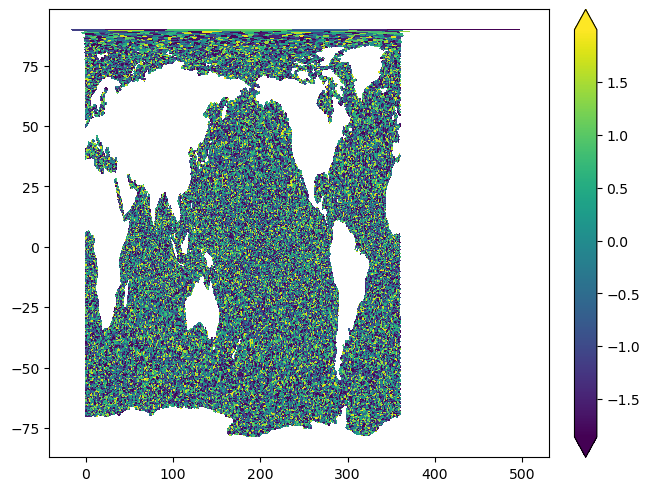

In [552]:
# scratch plot to check stuff
# set up mesh to apply polypcolor
masked_mesh_ds.attrs['on_a_sphere'] = 'YES'
masked_mesh_ds.attrs['is_periodic'] = 'YES'
masked_mesh_ds.attrs['x_period'] = 360
masked_mesh_ds.attrs['y_period'] = 0.0

# scratch plot to check stuff
# set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

# Mosaic descriptor object, needed to plot the polygons
# descriptor = mosaic.Descriptor(masked_mesh_ds,use_latlon=False)
descriptor = mosaic.Descriptor(mesh,use_latlon=False)

ds_formatted = format_ds(dso.isel(Time=0),'timeMonthly_avg_activeTracers_temperature',mesh,mask)

# plot
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)

ds_t0 = ds_formatted['timeMonthly_avg_activeTracers_temperature'].isel(nVertLevels=0)

c = mosaic.polypcolor(ax,descriptor,
                  ds_t0,cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')

In [387]:
mesh.latCell

<xarray.DataArray 'latCell' (nCells: 236853)> Size: 2MB
array([ 1.56982964, -0.46330786, -0.46346924, ..., -0.20522028,
        0.44590281,  0.14292051], shape=(236853,))
Dimensions without coordinates: nCells
Attributes:
    units:      radians
    long_name:  Latitude location of cell centers in radians.

In [378]:
mesh.lonEdge.dims

"('nEdges',)"

In [375]:
for x in mesh.lonEdge.dims:
    print(x)

nEdges


In [376]:
str(x)

'nEdges'

In [381]:
datavariable='lonEdge'
for x in mesh[datavariable].dims:
    dim = str(x)
dim

'nEdges'

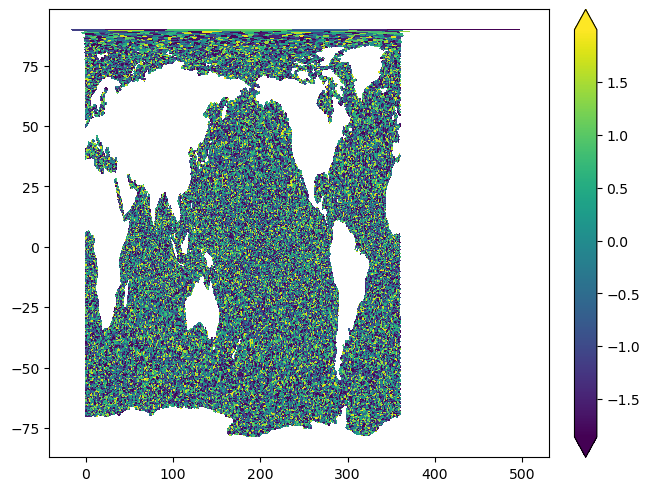

In [357]:
# scratch plot to check stuff
# set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

# Mosaic descriptor object, needed to plot the polygons
descriptor = mosaic.Descriptor(mesh,use_latlon=False)


# plot
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)

c = mosaic.polypcolor(ax,descriptor,
                  ds_formatted['timeMonthly_avg_activeTracers_temperature'].isel(nVertLevels=0),cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')
# ax.set_xlim(290, 315)
# ax.set_ylim(51.5, 68)
# ax.set_title(ds_name + '\n Level=30, time=0')

In [52]:
mesh

<xarray.Dataset> Size: 1GB
Dimensions:                        (nCells: 236853, nEdges: 719506,
                                    nVertices: 482371, TWO: 2, maxEdges: 7,
                                    maxEdges2: 14, vertexDegree: 3,
                                    nVertLevels: 60, Time: 1,
                                    nVertLevelsP1: 61, nForcingGroupsMax: 4)
Coordinates:
    VertexID                       (nVertices) int32 2MB ...
Dimensions without coordinates: nCells, nEdges, nVertices, TWO, maxEdges,
                                maxEdges2, vertexDegree, nVertLevels, Time,
                                nVertLevelsP1, nForcingGroupsMax
Data variables: (12/73)
    latCell                        (nCells) float64 2MB 89.94 -26.55 ... 8.189
    lonCell                        (nCells) float64 2MB 339.1 36.09 ... 134.5
    xCell                          (nCells) float64 2MB ...
    yCell                          (nCells) float64 2MB ...
    zCell                          (nCells) float64 2MB ...
    indexToCellID                  (nCells) int32 947kB ...
    ...                             ...
    accumulatedLandIceFrazilMass   (Time, nCells) float64 2MB ...
    frazilSurfacePressure          (Time, nCells) float64 2MB ...
    filteredSSHGradientZonal       (Time, nCells) float64 2MB ...
    filteredSSHGradientMeridional  (Time, nCells) float64 2MB ...
    forcingGroupNames              (Time, nForcingGroupsMax) |S64 256B ...
    forcingGroupRestartTimes       (Time, nForcingGroupsMax) |S64 256B ...
Attributes: (12/1163)
    on_a_sphere:                                                   YES
    sphere_radius:                                                 6371229.0
    model_name:                                                    mpas
    core_name:                                                     ocean
    history:                                                       Thu Feb 11...
    source:                                                        MPAS
    ...                                                            ...
    config_rx1_zstar_weight:                                       1.0
    config_rx1_horiz_smooth_open_ocean_cells:                      20
    config_rx1_min_levels:                                         3
    config_rx1_min_layer_thickness:                                1.0
    file_id:                                                       99ljfzad8z
    NCO:                                                           netCDF Ope...

In [42]:
distance = np.sqrt((mesh.latVertex)**2 + (mesh.lonVertex)**2)
start_idx = distance.argmin() # index starts at 0, but vertex id starts at 1
start_vid = start_idx + 1

In [72]:
# id the edges attached to the start vertex
e_id = mesh.edgesOnVertex.isel(nVertices=start_idx)

# grab one of the edges that is attached to the vertex. then subtract to make an index
edge_idx0 = e_id.isel(vertexDegree=0) - 1

# get the vertices attached to the other side
next_vid = mesh.verticesOnEdge.isel(nEdges=edge_idx0)

# eliminate the previous vertex id from the array
next_vid.where(next_vid!= start_vid.values).dropna(dim='TWO')



<xarray.DataArray 'verticesOnEdge' (TWO: 1)> Size: 8B
array([471653.])
Coordinates:
    VertexID  int32 4B 318330
Dimensions without coordinates: TWO
Attributes:
    units:      unitless
    long_name:  List of vertices that straddle each edge.

In [71]:
next_vid

<xarray.DataArray 'verticesOnEdge' (TWO: 2)> Size: 8B
array([318330, 471653], dtype=int32)
Coordinates:
    VertexID  int32 4B ...
Dimensions without coordinates: TWO
Attributes:
    units:      unitless
    long_name:  List of vertices that straddle each edge.

In [43]:
mesh.edgesOnVertex

<xarray.DataArray 'edgesOnVertex' (nVertices: 482371, vertexDegree: 3)> Size: 6MB
array([[374182, 420544, 619670],
       [ 33222, 615194,  54518],
       [243990, 433658, 427239],
       ...,
       [526813, 617865, 631189],
       [ 75923, 284918, 617865],
       [ 51453, 631189, 446007]], shape=(482371, 3), dtype=int32)
Dimensions without coordinates: nVertices, vertexDegree
Attributes:
    units:      unitless
    long_name:  List of edges that share a vertex as an endpoint.

In [41]:
mesh.indexToVertexID.values

array([     1,      2,      3, ..., 482369, 482370, 482371],
      shape=(482371,), dtype=int32)

In [13]:
mesh.lonVertex[idx]

<xarray.DataArray 'lonVertex' ()> Size: 8B
array(0.00087021)
Attributes:
    units:      radians
    long_name:  Longitude location of vertices in radians.

In [12]:
mesh.latVertex[idx]

<xarray.DataArray 'latVertex' ()> Size: 8B
array(0.00200711)
Attributes:
    units:      radians
    long_name:  Latitude location of vertices in radians.

In [17]:
wanted_lat = -30
wanted_lon = 100

# # find the values closest to the wanted latitude
# mesh_lat = np.abs(wanted_lat - mesh.latCell).argmin()

# # find the values closest to the wanted longitude
# mesh_lon = np.abs(wanted_lon - mesh.lonCell).argmin()

In [28]:
mesh

<xarray.Dataset> Size: 1GB
Dimensions:                        (nCells: 236853, nEdges: 719506,
                                    nVertices: 482371, TWO: 2, maxEdges: 7,
                                    maxEdges2: 14, vertexDegree: 3,
                                    nVertLevels: 60, Time: 1,
                                    nVertLevelsP1: 61, nForcingGroupsMax: 4)
Dimensions without coordinates: nCells, nEdges, nVertices, TWO, maxEdges,
                                maxEdges2, vertexDegree, nVertLevels, Time,
                                nVertLevelsP1, nForcingGroupsMax
Data variables: (12/73)
    latCell                        (nCells) float64 2MB 89.94 -26.55 ... 8.189
    lonCell                        (nCells) float64 2MB 339.1 36.09 ... 134.5
    xCell                          (nCells) float64 2MB ...
    yCell                          (nCells) float64 2MB ...
    zCell                          (nCells) float64 2MB ...
    indexToCellID                  (nCells) int32 947kB ...
    ...                             ...
    accumulatedLandIceFrazilMass   (Time, nCells) float64 2MB ...
    frazilSurfacePressure          (Time, nCells) float64 2MB ...
    filteredSSHGradientZonal       (Time, nCells) float64 2MB ...
    filteredSSHGradientMeridional  (Time, nCells) float64 2MB ...
    forcingGroupNames              (Time, nForcingGroupsMax) |S64 256B ...
    forcingGroupRestartTimes       (Time, nForcingGroupsMax) |S64 256B ...
Attributes: (12/1163)
    on_a_sphere:                                                   YES
    sphere_radius:                                                 6371229.0
    model_name:                                                    mpas
    core_name:                                                     ocean
    history:                                                       Thu Feb 11...
    source:                                                        MPAS
    ...                                                            ...
    config_rx1_zstar_weight:                                       1.0
    config_rx1_horiz_smooth_open_ocean_cells:                      20
    config_rx1_min_levels:                                         3
    config_rx1_min_layer_thickness:                                1.0
    file_id:                                                       99ljfzad8z
    NCO:                                                           netCDF Ope...

In [26]:
mesh.nCells[mesh_lat]

<xarray.DataArray 'nCells' ()> Size: 8B
array(39845)

In [16]:
dso.isel(

<xarray.DataArray 'lonCell' ()> Size: 8B
array(99.99953487)

In [ ]:
condition = (mesh.latCell<-30) #(mesh.xCell==40000)&

# apply a .where to the mesh
where_applied = mesh.where(condition)

# get the indices of where the condition applies and save as a mask
mask = where_applied.xCell.notnull().values

# apply the mask to the nCells variable
masked_nCells = mesh.nCells[mask]

# apply the masked nCells (values of nCells for which the condition is true) to the dataset you want to look at
masked_ds = dso.where(dso.nCells.isin(masked_nCells))

### idealized mesh

In [12]:
# idealized mesh
rootdir = '/pscratch/sd/k/kuyeda/bichan/mpaso/10km/'
mesh = xr.open_dataset(rootdir + 'channel_10km_init.nc')

# idealized data
dso = xr.open_dataset(rootdir + 'output_member1.nc', chunks={'Time': 1}).isel(Time=0,nVertLevels=0)

In [18]:
condition = (mesh.latCell<-30) #(mesh.xCell==40000)&

# apply a .where to the mesh
where_applied = mesh.where(condition)

# get the indices of where the condition applies and save as a mask
mask = where_applied.xCell.notnull().values

# apply the mask to the nCells variable
masked_nCells = mesh.nCells[mask]

# apply the masked nCells (values of nCells for which the condition is true) to the dataset you want to look at
masked_ds = dso.where(dso.nCells.isin(masked_nCells))

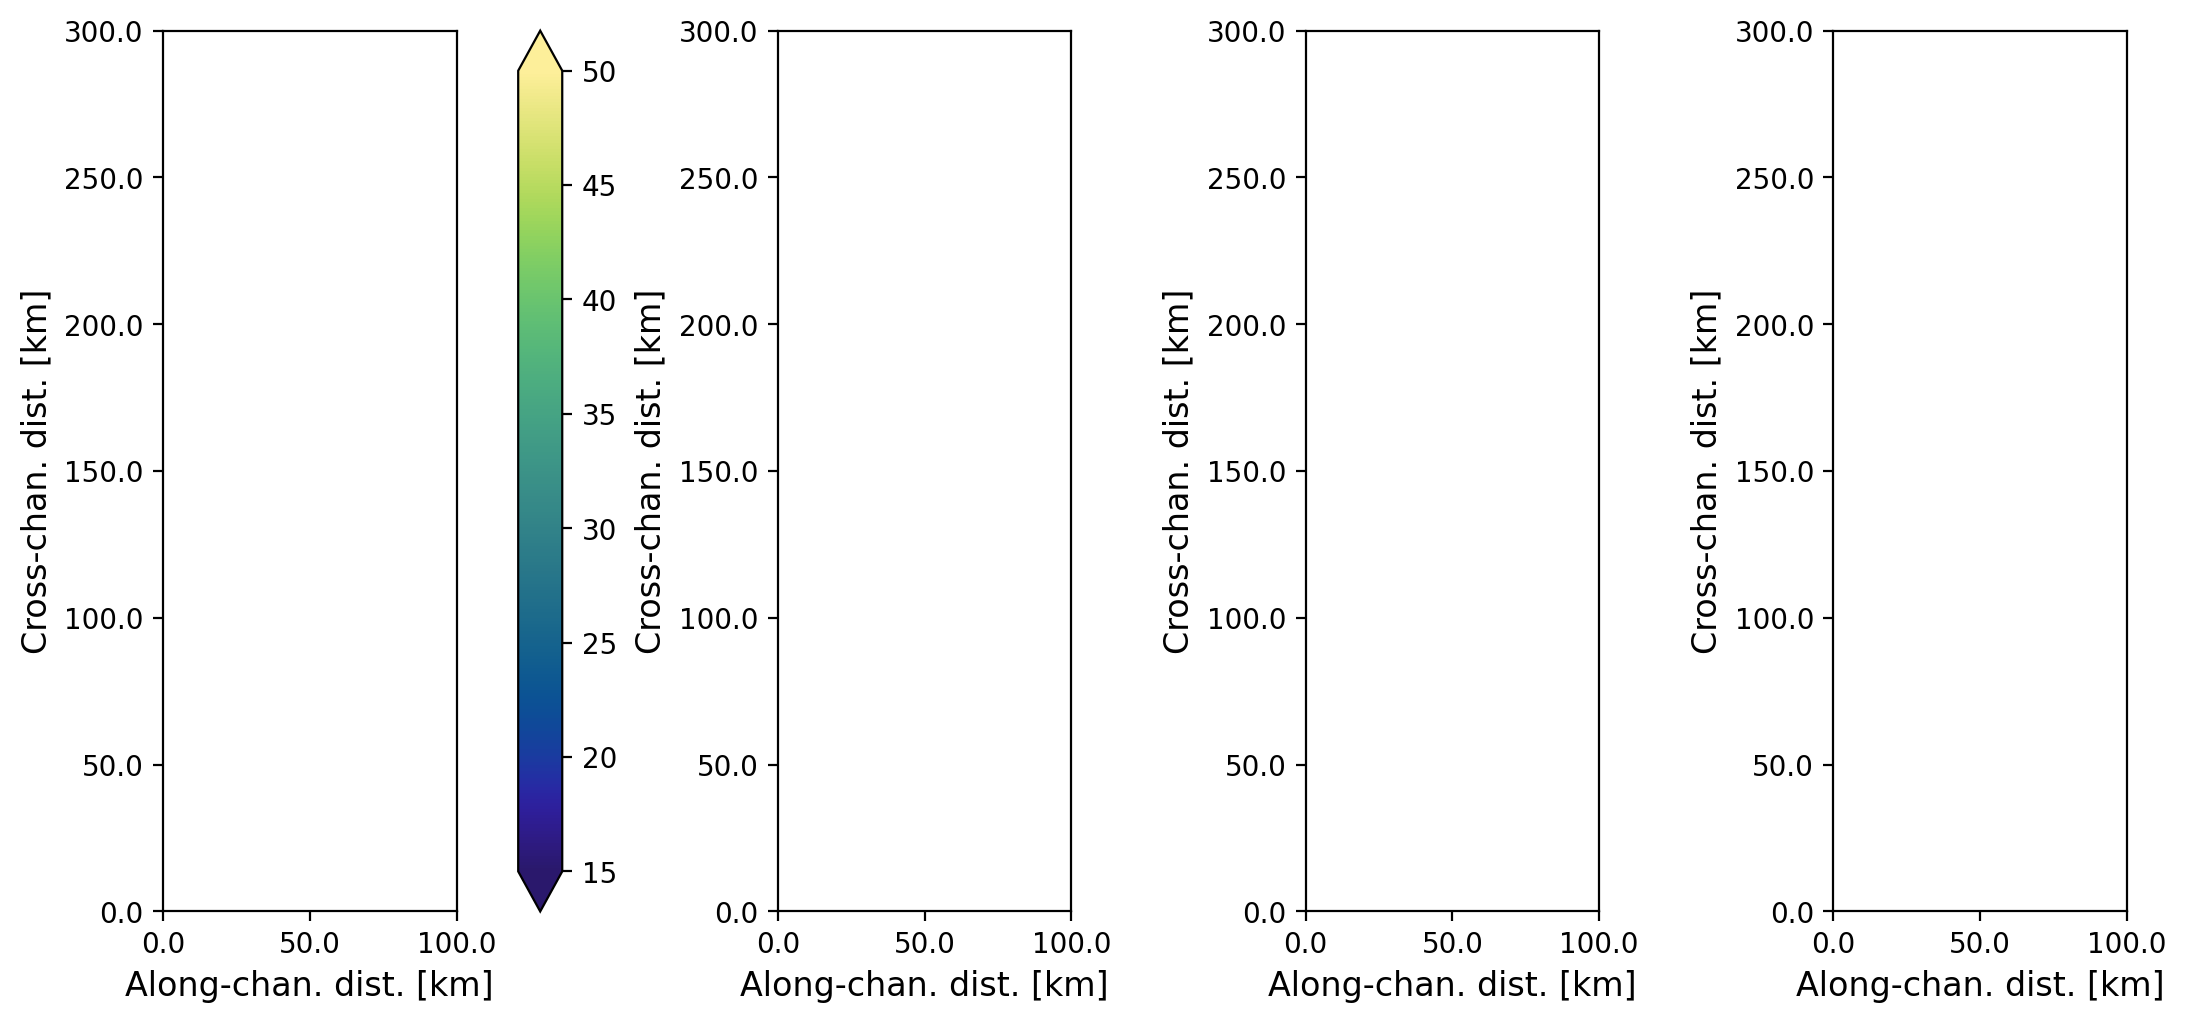

In [19]:
# very quick code to check if the locations chosen are correct
descriptor = mosaic.Descriptor(mesh,use_latlon=False)
z = 0; t=107 # First vertical layer, 10 days in @ hourly output 
fig, axes = plt.subplots(1, 4, figsize=(11, 5), constrained_layout=True, dpi = 200)

# Panel (a): Salinity
c = mosaic.polypcolor(axes[0], descriptor,
                      masked_ds.salinity,
                      cmap=cmo.haline, vmin=15, vmax=50,
                      antialiaseds=False)
fig.colorbar(c, ax=axes[0], extend='both')

for ax in axes:
    ax.set_xticks(np.arange(0, 350000, 50000))
    ax.set_yticks(np.arange(0, 350000, 50000))
    ax.set_xlim(0, 100000)
    ax.set_ylim(0, 300000)
    ax.set_aspect(1.0)
    ax.set_xticklabels([str(x / 1000.0) for x in ax.get_xticks()])
    ax.set_yticklabels([str(y / 1000.0) for y in ax.get_yticks()])
    ax.set_xlabel('Along-chan. dist. [km]', fontsize=12)
    ax.set_ylabel('Cross-chan. dist. [km]', fontsize=12)